# Risk-adjusted performance

## 1.Загрузка библиотек

In [9]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt  # графическая библиотека
import math
import statsmodels.api as sm
import datetime
import collections

## 2.Полезные функции

In [10]:
### приведение доходностей к годовому выражению
def annualised_return(array, t):
    return (np.product(1 + np.array(array)))**(t /
                                               np.array(array).shape[0]) - 1


In [11]:
### вспомогательная функция для расчета биномиальных коэффициентов
def binom_coeff(n, k):
    return math.factorial(n) / (math.factorial(k) * math.factorial(n - k))


In [12]:
### функция для расчета начальных моментов
def non_central_moments(mu, sigma, skew, kurt, m=4):
    cm = {}
    cm[2] = (sigma**2)
    cm[3] = (skew * sigma**3)
    cm[4] = ((kurt + 3) * sigma**4)
    ncm = {}
    ncm[1] = mu
    for n in range(2, m + 1):
        #   print('n',n)
        sum_ = 0
        for k in range(1, n):
            #       print('n,k',n,k)
            #       print('bc',binom_coeff(n,k))
            sum_ += ((-1)**(n - k + 1)) * binom_coeff(
                n, k) * (ncm[1]**(n - k)) * ncm[k]
        ncm[n] = ((-1)**(n + 1) * (ncm[1]**n) + sum_ + cm[n])
    # print(((-1)**(n+1)*(ncm[1]**n)/sum_,cm[n]))
    return ncm


In [13]:
### функция для расчета кумулянтов
def cumulants(ncm, t, m=4):
    cum = {}
    cum[1] = ncm[1]
    for n in range(2, m + 1):
        sum_ = 0
        for k in range(1, n):
            sum_ += binom_coeff(n - 1, k - 1) * cum[k] * ncm[n - k]
        cum[n] = (ncm[n] - sum_)
    cum[1] = cum[1]
    for key in cum.keys():
        cum[key] = cum[key] * t
    return cum


In [14]:
### функция для расчета начальных моментов с учетом времени
def non_central_moments_t(cum, m=4):
    ncm_t = {}
    ncm_t[1] = cum[1]
    for n in range(2, m + 1):
        sum_ = 0
        for k in range(1, n):
            sum_ += binom_coeff(n - 1, k - 1) * cum[k] * ncm_t[n - k]
        ncm_t[n] = cum[n] + sum_
    #  print(ncm_t[n],sum_)
    return ncm_t


In [15]:
### функция для расчета центральных моментов с учетом времени
def central_moments_t(ncm_t, m=4):
    cm_t = {}
    cm_t[1] = ncm_t[1]
    for n in range(2, m + 1):
        #  print('n',n)
        sum_ = 0
        for k in range(1, n):
            #      print('n,k',n,k)
            #     print('bc',binom_coeff(n,k))
            sum_ += ((-1)**(n - k)) * binom_coeff(
                n, k) * (ncm_t[1]**(n - k)) * ncm_t[k]
        cm_t[n] = (-1)**(n) * (ncm_t[1]**n) + sum_ + ncm_t[n]
    #  print((-1)**n*(ncm_t[1]**n),sum_,ncm_t[n])
    #print(sum_)
    return cm_t

In [16]:
### функция для расчета асимметрии и эксцесса, приведенных к годовому выражению
def statistics_annualised(mu, sigma, skew, kurt, t, m=4):
    ncm = non_central_moments(mu, sigma, skew, kurt)
    cum = cumulants(ncm, t)
    ncm_t = non_central_moments_t(cum)
    cm_t = central_moments_t(ncm_t)
    return (cum[3] / (cum[2]**.5)**3, cum[4] / (cum[2]**.5)**4)


## 3.Загрузка и обработка данных

### Загрузка ESG-портфеля

In [17]:
port = pd.read_csv('.\\ap_data\\port_esg.csv',
                   index_col='Date',
                   parse_dates=True)


In [18]:
port.head()

,NVDA,MSFT,BBY,ADBE,POOL,CRM,CDNS,INTU,IDXX,LRCX,^GSPC
Date,,,,,,,,,,,
2017-12-29,48.375000,85.540001,68.470001,175.240005,129.649994,102.230003,41.820000,157.779999,156.380005,184.070007,2673.610107
2018-01-02,49.837502,85.949997,69.160004,177.699997,131.169998,104.410004,42.049999,158.720001,157.809998,189.279999,2695.810059
2018-01-03,53.117500,86.349998,68.400002,181.039993,131.029999,105.290001,42.930000,159.160004,162.050003,192.500000,2713.060059
2018-01-04,53.397499,87.110001,67.279999,183.220001,132.039993,106.680000,43.580002,162.009995,163.960007,193.380005,2723.989990
2018-01-05,53.849998,88.190002,68.870003,185.339996,132.199997,108.099998,43.990002,164.110001,166.600006,196.399994,2743.149902


### Загрузка Fama-French factors. Для целей анализа используется недельный интервал.

In [19]:
ff = pd.read_csv(
    '.\\ap_data\\F-F_Research_Data_Factors_weekly.csv',
    skiprows=4)


In [20]:
ff.tail()

,Unnamed: 0,Mkt-RF,SMB,HML,RF
4991,20220304,-1.70,-0.38,2.10,0.0
4992,20220311,-2.86,1.52,2.20,0.0
4993,20220318,6.59,-0.10,-5.52,0.0
4994,20220325,1.55,-2.47,2.19,0.0
4995,Copyright 2022 Kenneth R. French,NaN,NaN,NaN,NaN


In [21]:
ff.rename({'Unnamed: 0': 'Date'}, axis=1, inplace=True)


In [22]:
ff = ff.iloc[:-1, :]


In [23]:
ff.tail()

,Date,Mkt-RF,SMB,HML,RF
4990,20220225,0.91,0.38,-1.30,0.0
4991,20220304,-1.70,-0.38,2.10,0.0
4992,20220311,-2.86,1.52,2.20,0.0
4993,20220318,6.59,-0.10,-5.52,0.0
4994,20220325,1.55,-2.47,2.19,0.0


In [24]:
ff.Date = pd.to_datetime(ff.Date, format='%Y%m%d')


In [25]:
ff.tail()

,Date,Mkt-RF,SMB,HML,RF
4990,2022-02-25,0.91,0.38,-1.30,0.0
4991,2022-03-04,-1.70,-0.38,2.10,0.0
4992,2022-03-11,-2.86,1.52,2.20,0.0
4993,2022-03-18,6.59,-0.10,-5.52,0.0
4994,2022-03-25,1.55,-2.47,2.19,0.0


In [26]:
ff.Date.dt.day_name()

0         Friday
1       Saturday
2       Saturday
3       Saturday
4       Saturday
          ...   
4990      Friday
4991      Friday
4992      Friday
4993      Friday
4994      Friday
Name: Date, Length: 4995, dtype: object

In [27]:
ff.dtypes

Date      datetime64[ns]
Mkt-RF           float64
SMB              float64
HML              float64
RF               float64
dtype: object

## 4. Формирование портфеля и расчет доходности

### Массив весов. Все активы входят в портфель с одинаковыми весами.

In [28]:
weight = 1 / (port.shape[1] - 1)
weight

0.1

In [29]:
weight_array = np.repeat(weight, port.shape[1] - 1)


In [30]:
weight_array = np.expand_dims(weight_array, axis=1)


In [31]:
weight_array.shape

(10, 1)

### Переход от дневных к недельным данным

In [32]:
port_week = port.resample('W-FRI').last()


In [33]:
port_week.head()

,NVDA,MSFT,BBY,ADBE,POOL,CRM,CDNS,INTU,IDXX,LRCX,^GSPC
Date,,,,,,,,,,,
2017-12-29,48.375000,85.540001,68.470001,175.240005,129.649994,102.230003,41.820000,157.779999,156.380005,184.070007,2673.610107
2018-01-05,53.849998,88.190002,68.870003,185.339996,132.199997,108.099998,43.990002,164.110001,166.600006,196.399994,2743.149902
2018-01-12,55.744999,89.599998,73.250000,195.050003,131.210007,110.239998,45.070000,164.509995,173.240005,188.509995,2786.239990
2018-01-19,57.527500,90.000000,76.860001,195.729996,130.550003,111.930000,45.599998,167.740005,180.630005,207.529999,2810.300049
2018-01-26,60.832500,94.059998,77.849998,201.300003,135.669998,113.699997,45.799999,170.440002,187.029999,202.570007,2872.870117


### Расчет недельной доходности

In [34]:
port_week_return = port_week.apply(lambda x: (x - x.shift(1)) / x.shift(1))


In [35]:
port_week_return = port_week_return.iloc[1:, :]


In [36]:
port_week_return.head()

,NVDA,MSFT,BBY,ADBE,POOL,CRM,CDNS,INTU,IDXX,LRCX,^GSPC
Date,,,,,,,,,,,
2018-01-05,0.113178,0.030980,0.005842,0.057635,0.019668,0.057419,0.051889,0.040119,0.065354,0.066985,0.026010
2018-01-12,0.035190,0.015988,0.063598,0.052390,-0.007489,0.019796,0.024551,0.002437,0.039856,-0.040173,0.015708
2018-01-19,0.031976,0.004464,0.049283,0.003486,-0.005030,0.015330,0.011759,0.019634,0.042658,0.100897,0.008635
2018-01-26,0.057451,0.045111,0.012881,0.028458,0.039219,0.015813,0.004386,0.016096,0.035432,-0.023900,0.022265
2018-02-02,-0.040316,-0.024240,-0.084907,-0.028117,-0.023439,-0.025682,-0.102620,-0.041188,-0.003582,-0.116059,-0.038547


In [37]:
port_week_return['Return'] = np.dot(np.array(port_week_return.iloc[:, :-1]),
                                    weight_array)


In [38]:
port_week_return.head()

,NVDA,MSFT,BBY,ADBE,POOL,CRM,CDNS,INTU,IDXX,LRCX,^GSPC,Return
Date,,,,,,,,,,,,
2018-01-05,0.113178,0.030980,0.005842,0.057635,0.019668,0.057419,0.051889,0.040119,0.065354,0.066985,0.026010,0.050907
2018-01-12,0.035190,0.015988,0.063598,0.052390,-0.007489,0.019796,0.024551,0.002437,0.039856,-0.040173,0.015708,0.020615
2018-01-19,0.031976,0.004464,0.049283,0.003486,-0.005030,0.015330,0.011759,0.019634,0.042658,0.100897,0.008635,0.027446
2018-01-26,0.057451,0.045111,0.012881,0.028458,0.039219,0.015813,0.004386,0.016096,0.035432,-0.023900,0.022265,0.023095
2018-02-02,-0.040316,-0.024240,-0.084907,-0.028117,-0.023439,-0.025682,-0.102620,-0.041188,-0.003582,-0.116059,-0.038547,-0.049015


In [40]:
np.dot(np.array(port_week_return.iloc[1, :-2]), weight_array)


array([0.02061459])

### Добавление risk-free rate

In [41]:
port_week_return = port_week_return.merge(ff[['Date', 'RF']],
                                          left_index=True,
                                          right_on='Date')


In [42]:
port_week_return.index = port_week_return.Date


In [43]:
port_week_return.drop('Date', axis=1, inplace=True)


In [44]:
port_week_return.tail()

,NVDA,MSFT,BBY,ADBE,POOL,CRM,CDNS,INTU,IDXX,LRCX,^GSPC,Return,RF
Date,,,,,,,,,,,,,
2021-11-26,-0.044930,-0.039142,-0.156909,-0.038163,-0.030867,-0.056314,-0.051882,-0.036731,-0.061412,-0.003910,-0.021997,-0.052026,0.001
2021-12-03,-0.025712,-0.020232,-0.077546,-0.068826,-0.025662,-0.091095,-0.002747,-0.028415,-0.034534,0.030359,-0.012230,-0.034441,0.002
2021-12-10,-0.016127,0.060463,-0.019363,0.061505,0.032725,0.029847,0.035250,0.046284,0.036417,0.067259,0.038249,0.033426,0.002
2021-12-17,-0.079376,-0.054709,-0.036505,-0.149454,-0.039153,-0.049243,-0.027099,-0.085080,0.014772,-0.052113,-0.019393,-0.055796,0.002
2021-12-31,-0.007726,0.004870,0.035889,-0.004494,0.029746,0.003911,-0.006027,0.011813,0.020837,0.029239,0.008547,0.011806,0.002


## 5. Расчет различных характеристик портфеля (risk-adjusted performance)

## 5.1. Descriptive statitistics (описательная статистика)

In [45]:
Port = port_week_return.Return  ## создание отдельного массива доходностей (портфель)


In [46]:
Bench = port_week_return[
    '^GSPC']  ## создание отдельного массива доходностей (benchmark)


In [47]:
RF = port_week_return.RF / 100  ## создание отдельного массива безрисковых ставок


In [48]:
t = 52  ## количество недель в году


### Portfolio mean return

In [49]:
np.mean(Port)

0.0062942248599641695

### Portfolio annualised return

## $r=(\prod_{i=1}^{i=n}(1+r_i))^\frac{t}{n}-1$

In [50]:
Port_annualised = annualised_return(Port, t)
Port_annualised

0.34002973506319756

### Portfolio Volatility

In [51]:
np.std(Port)

0.03594213203263802

### Portfolio annualised volatility 

## $\sigma_T=\sigma_t\sqrt{t}$

In [52]:
np.std(Port) * (t**.5)


0.25918239998634623

### Benchmark mean return

In [53]:
np.mean(Bench)

0.002149347600458347

### Benchmark annualised return

In [54]:
Bench_annualised = annualised_return(Bench, t)
Bench_annualised

0.09727437686769491

### Benchmark Volatility

In [55]:
np.std(Bench)

0.02658065708679129

### Annualised volatility

In [56]:
Bench_annualised = annualised_return(Bench, t)
Bench_annualised

0.09727437686769491

In [57]:
np.std(Bench) * t**.5


0.1916758441239025

### Risk-free annualised return

In [58]:
RF_annualised = annualised_return(RF, t)
RF_annualised

0.012160276511834045

### Skew and Kurtosis (Ассиметрия и эксцесс)

### В дополнение к основным портфельным характеристикам, таким как риск и доходность, в инвестиционном анализе активно испольутся показатели ассиметрии (skew) и эксцесса (kurtosis). Данные показатели основаны на третьем и четвертом центральных моментах распределения. Ассиметрия показывает, в какую сторону смещено распределение, эксцесс - степень островершинности распределения.

In [59]:
stats.skew(Port)

-0.3317403837885604

In [60]:
stats.kurtosis(Port, fisher=True)

3.82288486362593

### Проверка нормальности распределения

### Для проверки соответствия эмпирического распределения теоретическому закону используется большое количество тестов или, так назыаемых, критериев согласия. Непосредственно саму проверку гипотезы удобнее проводить путем сравнения p-value и уровня значимости $\alpha$ (ошибки первого рода.)

In [61]:
stats.normaltest(Port)

NormaltestResult(statistic=27.773079077008504, pvalue=9.314348982501404e-07)

### Hurst Index

### Hurst Index дает оценку специфической харатеристики портфеля - mean reversion (возврат к средней). Значение индекса в диапазоне от 0 до 0.5 говорит о том, что доходность портфеля имеет тенденцию возврата к средней (после отрицательных или положительных всплесков доходности происходит возврат к долгосрочному среднему уровню). Значение индекса в диапазоне от 0.5 до 1 свидетельствует об устойчивости тренда в доходности портфеля (persistence). Значение индекса 0.5 говорит о случайном характере поведения доходности (отсутствие каких-либо устойчивых паттернов).

## $H=\frac{log(R/S)}{log(n)}$
## $R/S=\frac{[max(k^r)-min(k^r)]}{\sigma}$

In [62]:
RS = (max(np.cumsum(Port - np.mean(Port))) -
      min(np.cumsum(Port - np.mean(Port)))) / np.std(Port)


In [63]:
np.log(RS) / np.log(Port.shape[0])


0.5087920129420357

## 5.2. Классические риск-метрики (simple risk-measures)

### Sharpe ratio

## $SR=\frac{\mu-r_{f}}{\sigma}$

In [64]:
SR = (annualised_return(Port, t) - annualised_return(RF, t)) / (np.std(Port) *
                                                                t**.5)
SR

1.2650143627369594

### Annualised skews and kurtosis (асимметрия и эксцесс в годовом выражении)

In [65]:
skew_an, kurt_an = statistics_annualised(np.mean(Port), np.std(Port),
                                         stats.skew(Port),
                                         stats.kurtosis(Port, fisher=True), t)


In [66]:
skew_an, kurt_an


(-0.04600411399583682, 0.07351701660819097)

### Modified Sharpe ratio 

## $SR_{m}=SR[1+SR\frac{S}{6}+SR^2\frac{K}{24}]$
### K-kurtosis, S-skew

In [67]:
SR * (1 + (skew_an / 6) * SR - (kurt_an / 24) * SR**2)


1.2465435770883737

## 5.3. Drawdown (снижение стоимости портфеля или "просадка")

### Drawdown характеризует насколько сильно падает портфель за период наблюдения. Существуют различные варианты измерения просадки. Просадка обычно рассматривается как  непрерывное падение стоимости портфеля. В данном примере рассматривается пример рассчета максимальной просадки.

### Largest individual drawdown

In [68]:
### losing streak
min_drawdown = 1
drawdown = 1
losing_streak = False
date_list = {}
date_list_drawdown = {}
for index, value in Port.iteritems():
    if value < 0:
        if losing_streak == False:
            losing_streak = True
        drawdown *= (1 + value)
        date_list[index] = value
    else:
        if losing_streak == True:
            losing_streak = False
            if drawdown < min_drawdown:
                min_drawdown = drawdown
                #print(min_drawdown)
                # print(date_list)
                date_list_drawdown = date_list.copy()
            drawdown = 1
            date_list = {}


C:\Users\drouni\AppData\Local\Temp\ipykernel_19148\4271539611.py:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in Port.iteritems():


In [69]:
min_drawdown

0.6810912682060632

In [70]:
date_list_drawdown = collections.OrderedDict(sorted(
    date_list_drawdown.items()))


In [71]:
date_list_drawdown

OrderedDict([(Timestamp('2020-02-21 00:00:00'), -0.023635606143990566),
             (Timestamp('2020-02-28 00:00:00'), -0.0971482673160289),
             (Timestamp('2020-03-06 00:00:00'), -0.0034260196170907307),
             (Timestamp('2020-03-13 00:00:00'), -0.06537801721840247),
             (Timestamp('2020-03-20 00:00:00'), -0.17047131599367424)])

In [72]:
date_last_drawdown = list(date_list_drawdown.keys())[-1]
date_last_drawdown

Timestamp('2020-03-20 00:00:00')

In [73]:
date_first_drawdown = list(date_list_drawdown.keys())[0]
date_first_drawdown

Timestamp('2020-02-21 00:00:00')

In [74]:
product = min_drawdown
for index, value in Port[Port.index > date_last_drawdown].iteritems():
    product *= (1 + value)
    if product >= 1:
        recovery_date = index
        break

C:\Users\drouni\AppData\Local\Temp\ipykernel_19148\43669095.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in Port[Port.index > date_last_drawdown].iteritems():


In [75]:
recovery_date

Timestamp('2020-07-31 00:00:00')

### Recovery (восстановление после падения)

### Помимо самой просадки инвесторам небезинтересно понимать, сколько времения потребуется управляющему для восстановления стоимости портфеля (recovery).

In [76]:
(recovery_date - Port.idxmin()).days

133

In [77]:
recovery_date - datetime.timedelta(1)


Timestamp('2020-07-30 00:00:00')

In [78]:
df = Port[(Port.index >= date_first_drawdown)
          & (Port.index <= recovery_date)] + 1


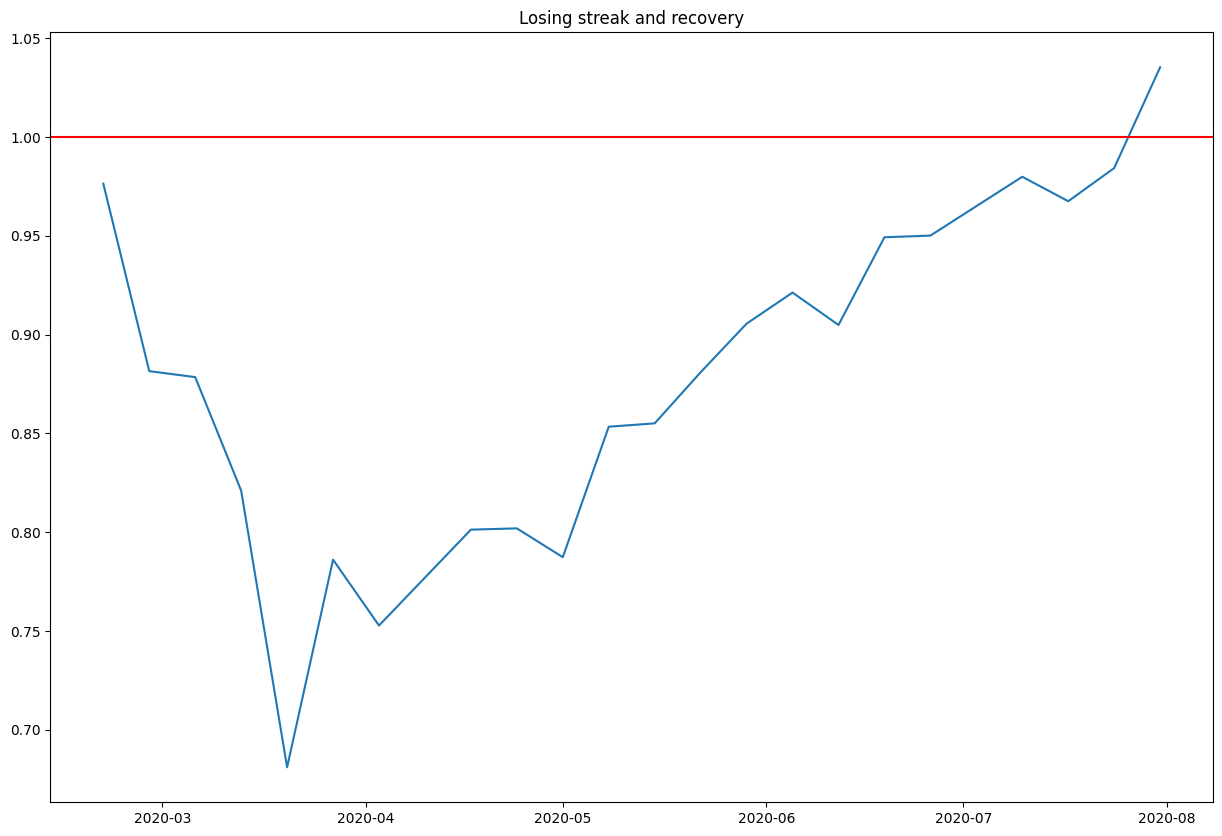

In [79]:
plt.figure(figsize=(15, 10))
plt.plot(df.cumprod())
plt.axhline(y=1, color='r', linestyle='-')
plt.title("Losing streak and recovery")
plt.show()

## 5.4. Portfolio and benchmark

### Correlation 

In [80]:
np.corrcoef(Port, Bench)


array([[1.        , 0.86941768],
       [0.86941768, 1.        ]])

## R-squared $R^2$

In [81]:
np.corrcoef(Port, Bench)[0, 1]**2


0.7558870999438287

### Active return

In [82]:
AR = Port - Bench


In [83]:
AR.head()

Date
2018-01-05    0.024897
2018-01-12    0.004906
2018-01-19    0.018810
2018-01-26    0.000830
2018-02-02   -0.010468
dtype: float64

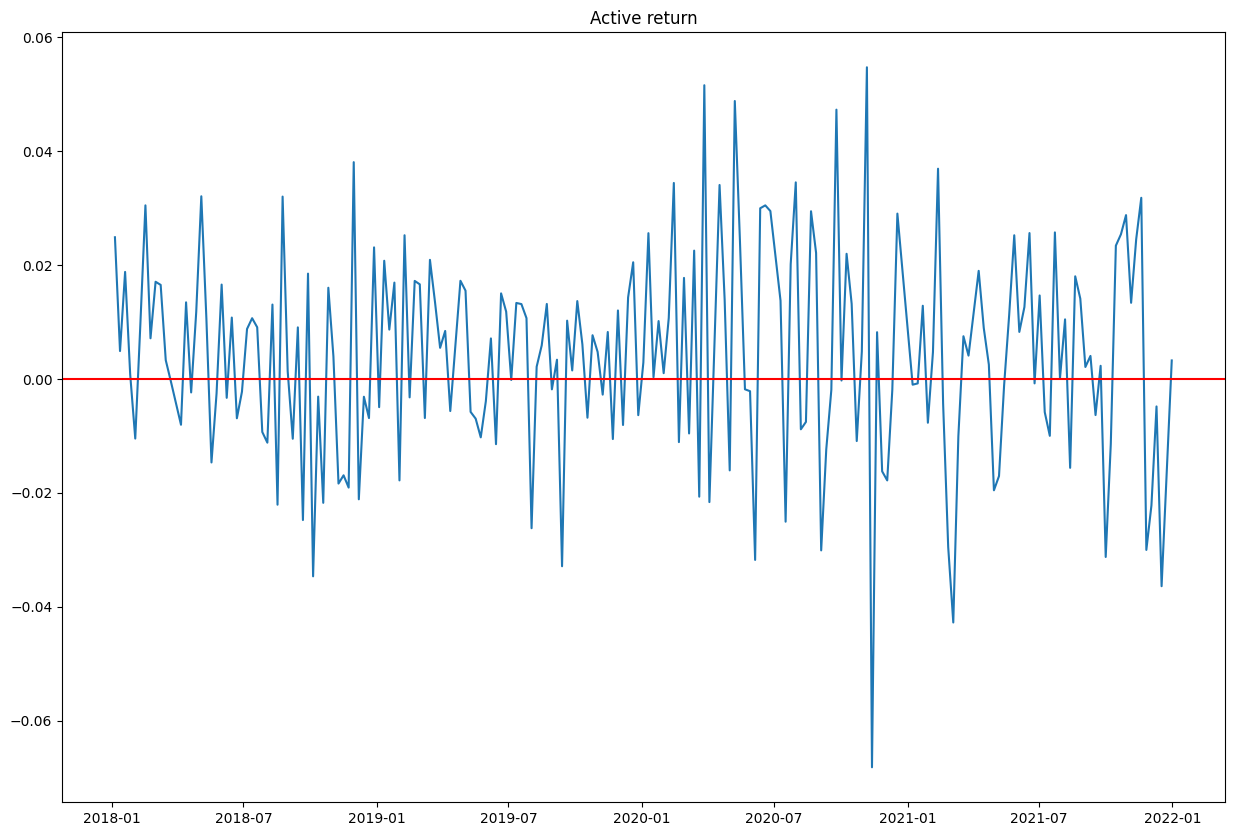

In [84]:
plt.figure(figsize=(15, 10))
plt.plot(AR)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Active return')
plt.show()

In [85]:
AR_mean = np.mean(AR)
AR_mean

0.004144877259505822

### Ex-post tracking error

## $\sigma_a=\sqrt{\frac{\sum_{j=1}^{j=n} (a_i-\bar{a})^2}{n}}$
### $a_i$ - active (excess) return
### $\bar{a}$ - mean active (excess) return

In [86]:
TR = np.std(AR)
TR

0.018361505905140105

### Anualised tracking error

In [87]:
TR * t**0.5


0.13240670207143496

### Information Ratio

## $IR=\frac{\bar{a}}{\sigma_a}$

In [88]:
IR = annualised_return(AR, t) / (TR * t**0.5)
IR

1.7310303553634139

### Up capture indicator - Return

## $\frac{\bar{r}^+}{\bar{b}^+}$
### $r^+$ - средняя положительная доходность портфеля
### $b^+$ - средняя положительная доходность бенчмарка

### Индикатор показывает, в какой степени портфель соответствует бенчмарку на растущем рынке (другими словами, насколько опережает или, наоборот, отстает доходность портфеля от доходности бенчмарка при положительном тренде). Чем выше показатель, тем эффективнее портфельный управляющий.

In [89]:
np.mean(Port[Port > 0]) / np.mean(Bench[Bench > 0])


1.6325083261146374

### Down capture indicator - Risk

## $\frac{\bar{r}^-}{\bar{b}^-}$
### $r^-$ - средняя отрицательная доходность портфеля
### $b^-$ - средняя отрицательная доходность бенчмарка

### Индикатор показывает, в какой степени портфель соответствует бенчмарку на падающем рынке (другими словами, насколько опережает или, наоборот, отстает доходность портфеля от доходности бенчмарка при негативном тренде). Чем ниже показатель, тем эффективнее портфельный управляющий.

In [90]:
np.mean(Port[Port < 0]) / np.mean(Bench[Bench < 0])


1.2576427421288485

### Up number  ratio

### Показывает процентное соотношение между количеством периодов с положительной доходностью портфеля (и одновременно пложительным значением бенчмарка) и общим количеством периодов с положительным значением бенчмарка. Должен стремиться к 100%. Модификация данного индикатора - Up percentage ratio - учитывает активный доход и показывет, в какой степени портфельный управляющий опережает рынок.

In [91]:
(Port > 0) & (Bench > 0)


Date
2018-01-05     True
2018-01-12     True
2018-01-19     True
2018-01-26     True
2018-02-02    False
              ...  
2021-11-26    False
2021-12-03    False
2021-12-10     True
2021-12-17    False
2021-12-31     True
Length: 201, dtype: bool

In [92]:
np.count_nonzero(((Port) > 0) & (Bench > 0)) / np.count_nonzero(Bench > 0)


0.8099173553719008

### Down number ratio

### Аналогичен предыдущему, используется для характеристики управления портфелем на падающем рынке. Должен стремиться к 0.

In [93]:
np.count_nonzero(((Port) > 0) & (Bench < 0)) / np.count_nonzero(Bench < 0)


0.275

##  5.5. Beta and Jensen's Alpha

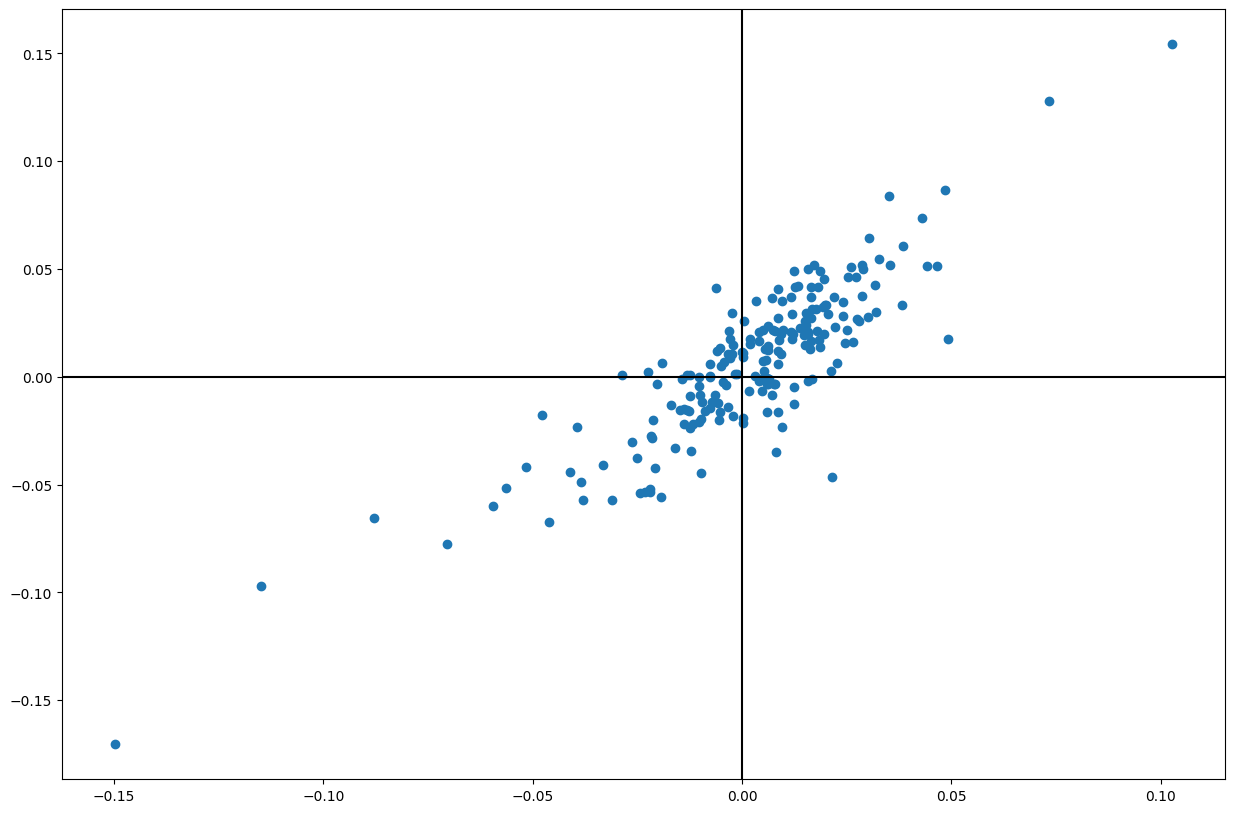

In [94]:
plt.figure(figsize=(15, 10))
plt.scatter(Bench, Port)
plt.axhline(y=0, color='black', linestyle='-')
plt.axvline(x=0, color='black', linestyle='-')
plt.show()

## $r-r_f=\alpha+\beta(b-r_f)+\epsilon$

In [95]:
Y = Port - RF
X = sm.add_constant(np.array(Bench - RF), prepend=True)


In [96]:
sm.OLS(Y, X).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     616.8
Date:                Fri, 28 Oct 2022   Prob (F-statistic):           6.96e-63
Time:                        22:45:43   Log-Likelihood:                 525.01
No. Observations:                 201   AIC:                            -1046.
Df Residuals:                     199   BIC:                            -1039.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.001      3.018      0.003       0.001       0.006
x1             1.1755      0.047     24.836      0.000       1.082       1.269
==============================================================================
Omnibus:                       11.662   Durbin-Watson:                   2.172
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               15.345
Skew:                          -0.403   Prob(JB):                     0.000465
Kurtosis:                       4.087   Cond. No.                         37.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [97]:
beta = list(sm.OLS(Y, X).fit().params)[1]
beta

1.175522090022819

In [98]:
alpha = list(sm.OLS(Y, X).fit().params)[0]
alpha

0.0038084259793075724

### Annualised alpha

In [99]:
a_alpha = (annualised_return(Port, t) - annualised_return(
    RF, t)) - beta * (annualised_return(Bench, t) - annualised_return(RF, t))
a_alpha

0.22781595341063

### Systematic and Specific Risks

## $\sigma^2=\sigma^2_S+\sigma^2_\epsilon=\beta^2\sigma^2_b+\sigma^2_\epsilon$
### $\sigma^2$ - Total risk
### $\sigma^2_S$ - Systematic risk
### $\sigma^2_\epsilon$ - Specific risk

### Specific risk

In [100]:
spec_r = sm.OLS(Y, X).fit().mse_resid


### Systematic risk

In [101]:
syst_r = beta * np.std(Bench - RF)
syst_r

0.031265143609070976

### Total risk

In [102]:
total_r = np.std(Port - RF)**2
total_r

0.0012928608124136171

In [103]:
syst_r**2 + spec_r


0.0012960301753032427

In [104]:
syst_r**2 + spec_r * 199 / 201


0.0012928608124136167

### Treynor ratio

## $TR=\frac{\mu-r_{f}}{\beta}$

In [105]:
(annualised_return(Port, t) - annualised_return(RF, t)) / beta


0.278913906709315

### Modified Treynor ratio

## $TR=\frac{\mu-r_{f}}{\sigma_s}$
### $\sigma_s$ - systematic risk

In [106]:
(annualised_return(Port, t) - annualised_return(RF, t)) / (syst_r * (t**.5))


1.4542493013044655

### Appraisal ratio

# $\frac{\alpha}{\sigma_\epsilon}$
### $\sigma_\epsilon$ - specific risk

In [107]:
a_alpha / ((spec_r * t)**.5)


1.7701637648188637

## 5.6. Regression models

### Market timing 

### Модель Teynor-Mazuy расширяет традиционный подход CAPM за счет включения в уравнение квадрата разности бенчмарка и безрисковой ставки. Положительное значение коэффициента $\gamma$ говорит о хороших предсказательных способностях стратегии с точки зрения времени входа/выхода.

## $r-r_f=\alpha+\beta(b-r_f)+\gamma(b-r_f)^2+\epsilon$

In [108]:
Y = np.array(Port - RF)
X = sm.add_constant(np.array([Bench - RF, (Bench - RF)**2]).T, prepend=True)


In [109]:
sm.OLS(Y, X).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     322.8
Date:                Fri, 28 Oct 2022   Prob (F-statistic):           4.80e-63
Time:                        22:45:46   Log-Likelihood:                 528.88
No. Observations:                 201   AIC:                            -1052.
Df Residuals:                     198   BIC:                            -1042.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      1.813      0.071      -0.000       0.005
x1             1.2352      0.051     24.111      0.000       1.134       1.336
x2             1.7865      0.641      2.788      0.006       0.523       3.050
==============================================================================
Omnibus:                       16.726   Durbin-Watson:                   2.167
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.705
Skew:                          -0.525   Prob(JB):                     7.12e-06
Kurtosis:                       4.314   Cond. No.                         518.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Модель Henriksson-Merton также расширяет традиционный подход CAPM за счет добавления в уравнение второй перменной, соответствующей платежной функции опциона.

##  $r-r_f=\alpha+\beta(b-r_f)+\gamma max(0,b-r_f)+\epsilon$

In [110]:
Y = Port - RF
X = sm.add_constant(np.concatenate(
    (np.array([Bench - RF]).T, np.maximum(0, np.array([Bench - RF])).T),
    axis=1),
                    prepend=True)


In [111]:
sm.OLS(Y, X).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     320.4
Date:                Fri, 28 Oct 2022   Prob (F-statistic):           8.39e-63
Time:                        22:45:46   Log-Likelihood:                 528.31
No. Observations:                 201   AIC:                            -1051.
Df Residuals:                     198   BIC:                            -1041.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.002      0.314      0.754      -0.003       0.004
x1             1.0393      0.071     14.720      0.000       0.900       1.178
x2             0.3459      0.134      2.572      0.011       0.081       0.611
==============================================================================
Omnibus:                       17.402   Durbin-Watson:                   2.152
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.757
Skew:                          -0.542   Prob(JB):                     4.21e-06
Kurtosis:                       4.334   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Bear beta $\beta^{-}$

In [112]:
df = pd.DataFrame({'Port': Port - RF, 'Bench': Bench - RF})


In [113]:
df[(df.Bench < 0) & (df.Port < 0)].head()


,Port,Bench
Date,,
2018-02-02,-0.049295,-0.038827
2018-02-09,-0.042348,-0.051900
2018-03-02,-0.003613,-0.020692
2018-03-16,-0.009386,-0.012692
2018-03-23,-0.060176,-0.059792


In [114]:
Y = df[(df.Bench < 0) & (df.Port < 0)]['Port']
X = df[(df.Bench < 0) & (df.Port < 0)]['Bench']


In [115]:
X = sm.add_constant(X, prepend=True)


In [116]:
sm.OLS(Y, X).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Port   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     174.3
Date:                Fri, 28 Oct 2022   Prob (F-statistic):           5.56e-19
Time:                        22:45:47   Log-Likelihood:                 168.26
No. Observations:                  59   AIC:                            -332.5
Df Residuals:                      57   BIC:                            -328.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0090      0.003     -3.552      0.001      -0.014      -0.004
Bench          0.9053      0.069     13.202      0.000       0.768       1.043
==============================================================================
Omnibus:                        0.305   Durbin-Watson:                   1.743
Prob(Omnibus):                  0.859   Jarque-Bera (JB):                0.428
Skew:                          -0.153   Prob(JB):                        0.807
Kurtosis:                       2.716   Cond. No.                         37.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [117]:
beta_down = list(sm.OLS(Y, X).fit().params)[1]


### Bull beta $\beta^{+}$

In [118]:
Y = df[(df.Bench > 0) & (df.Port > 0)]['Port']
X = df[(df.Bench > 0) & (df.Port > 0)]['Bench']


In [119]:
X = sm.add_constant(X, prepend=True)


In [120]:
sm.OLS(Y, X).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Port   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     154.4
Date:                Fri, 28 Oct 2022   Prob (F-statistic):           1.51e-21
Time:                        22:45:47   Log-Likelihood:                 271.75
No. Observations:                  96   AIC:                            -539.5
Df Residuals:                      94   BIC:                            -534.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0085      0.002      3.516      0.001       0.004       0.013
Bench          1.2166      0.098     12.426      0.000       1.022       1.411
==============================================================================
Omnibus:                        3.847   Durbin-Watson:                   2.359
Prob(Omnibus):                  0.146   Jarque-Bera (JB):                3.381
Skew:                          -0.294   Prob(JB):                        0.184
Kurtosis:                       3.708   Cond. No.                         66.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [121]:
beta_up = list(sm.OLS(Y, X).fit().params)[1]


### $\beta$-Timing ratio

## $\frac{\beta^+}{\beta^-}$

In [122]:
beta_up / beta_down


1.3438694342092934

### Fama-French three factors model

## $r-r_f=\alpha+\beta_3(b-r_f)+\beta_sSMB+\beta_vHML\epsilon$
### SMB - small-big (market capitalisation)
### HML - high-low (book to market ratio)

In [123]:
df = port_week_return.merge(ff[['Date', 'Mkt-RF', 'SMB', 'HML']],
                            left_index=True,
                            right_on='Date')


In [124]:
df.head()

,NVDA,MSFT,BBY,ADBE,POOL,CRM,CDNS,INTU,IDXX,LRCX,^GSPC,Return,RF,Date,Mkt-RF,SMB,HML
4774,0.113178,0.030980,0.005842,0.057635,0.019668,0.057419,0.051889,0.040119,0.065354,0.066985,0.026010,0.050907,0.028,2018-01-05,2.54,-0.67,-0.43
4775,0.035190,0.015988,0.063598,0.052390,-0.007489,0.019796,0.024551,0.002437,0.039856,-0.040173,0.015708,0.020615,0.028,2018-01-12,1.81,0.38,1.04
4776,0.031976,0.004464,0.049283,0.003486,-0.005030,0.015330,0.011759,0.019634,0.042658,0.100897,0.008635,0.027446,0.028,2018-01-19,0.84,-0.66,-0.41
4777,0.057451,0.045111,0.012881,0.028458,0.039219,0.015813,0.004386,0.016096,0.035432,-0.023900,0.022265,0.023095,0.028,2018-01-26,2.05,-1.50,-1.10
4778,-0.040316,-0.024240,-0.084907,-0.028117,-0.023439,-0.025682,-0.102620,-0.041188,-0.003582,-0.116059,-0.038547,-0.049015,0.028,2018-02-02,-3.81,-0.51,-0.14


In [125]:
Y = np.array(Port - RF)
X = sm.add_constant(np.array([df['Mkt-RF'] / 100, df['SMB'], df['HML']]).T,
                    prepend=True)


In [126]:
sm.OLS(Y, X).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     424.6
Date:                Fri, 28 Oct 2022   Prob (F-statistic):           1.06e-85
Time:                        22:45:48   Log-Likelihood:                 585.24
No. Observations:                 201   AIC:                            -1162.
Df Residuals:                     197   BIC:                            -1149.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.635      0.009       0.001       0.004
x1             1.2193      0.035     34.703      0.000       1.150       1.289
x2            -0.0017      0.001     -2.599      0.010      -0.003      -0.000
x3            -0.0046      0.000    -11.275      0.000      -0.005      -0.004
==============================================================================
Omnibus:                        2.376   Durbin-Watson:                   2.287
Prob(Omnibus):                  0.305   Jarque-Bera (JB):                1.979
Skew:                          -0.194   Prob(JB):                        0.372
Kurtosis:                       3.292   Cond. No.                         88.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 5.7. Partial moments

### Semivariance

## $\sigma^2_H=\sum_{i=1}^n\frac{min(r_i-\bar{r},0)^2}{n}$

In [127]:
np.mean(Port)

0.0062942248599641695

In [128]:
SV = np.sum(np.minimum(Port - np.mean(Port), 0)**2) / Port.shape[0]
SV


0.0006995722705352997

In [129]:
SV**.5

0.026449428548369427

### Downside variance and risk

### Target

In [130]:
target = 0.0035  ## целевая недельная доходность (в среднем)


In [131]:
((1 + target)**Port.shape[0])**(t / Port.shape[0]) - 1


0.1992330664952071

## $\sigma^2_H=\sum_{i=1}^n\frac{min(r_i-r_T,0)^2}{n}$

In [132]:
DV = np.sum(np.minimum(Port - target, 0)**2) / Port.shape[0]
DV

0.0006296164124127375

In [133]:
DR = DV**.5
DR

0.025092158384896614

### Downside potential

## $\sigma^2_H=\sum_{i=1}^n\frac{min(r_i-r_T,0)}{n}$ 

In [134]:
DP = np.sum(np.minimum(Port - target, 0)) / Port.shape[0]
DP

-0.011883758825690588

### Sortino ratio

## $TR=\frac{\mu-r_{f}}{\sigma_d}$

In [135]:
(annualised_return(Port, t) - annualised_return(RF, t)) / (DR * t**.5)


1.8120128428665896

### Upside variance and risk

## $\sigma^2_H=\sum_{i=1}^n\frac{max(r_i-r_T,0)^2}{n}$

In [136]:
UV = np.sum(np.maximum(Port - target, 0)**2) / Port.shape[0]
UV

0.0006700281352068879

In [137]:
UR = UV**.5
UR

0.025884901684319526

### Upside potential

## $\sigma^2_H=\sum_{i=1}^n\frac{max(r_i-r_T,0)}{n}$

In [138]:
UP = np.sum(np.maximum(Port - target, 0)) / Port.shape[0]
UP

0.014677983685654757

### Omega ratio

## $\omega=\frac{UP}{DP}$

In [139]:
UP / -DP


1.2351297178737377